In [1]:
import numpy as np
import matplotlib.cm as cm
import pandas as pd
from possibilearn.kernel import GaussianKernel
import math
import itertools as it
import gurobipy as gpy

source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

iris_df = pd.read_csv(
    filepath_or_buffer=source,
    header=None,
    sep=',')

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # drops the empty line at file-end

iris_values = iris_df.iloc[:,:4].values #array dei soli valori
iris_labels = iris_df.iloc[:,4].values #array delle etichette

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

iris_values_std = StandardScaler().fit_transform(iris_values)

pca_2d = PCA(n_components=2)
iris_values_2d = pca_2d.fit_transform(iris_values_std)

pca_3d = PCA(n_components=3)
iris_values_3d = pca_3d.fit_transform(iris_values_std)

pca_4d = PCA(n_components=4)
iris_values_4d = pca_4d.fit_transform(iris_values_std)

# print iris_values_2d

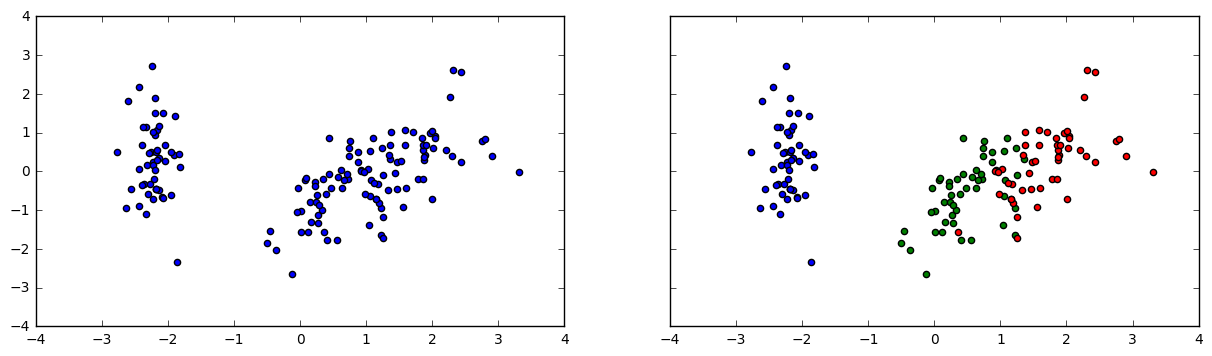

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

iris_values_2d = np.array(iris_values_2d)

fig, axs = plt.subplots(1, 2,
sharey=True, figsize=(15, 4))
fig.subplots_adjust(wspace=0.2)

axs[0].scatter(iris_values_2d[:,0],iris_values_2d[:,1]) #grafico di tutti i punti, senza appartenenza
axs[0].set_xlim(-4,4)

for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), #grafico con appartenenza
                        ('blue', 'green', 'red')):
        axs[1].scatter(iris_values_2d[iris_labels==lab, 0],
                    iris_values_2d[iris_labels==lab, 1],
                    label=lab,
                    c=col)
axs[1].set_xlim(-4,4)        

plt.show()

In [4]:
def chop(x, minimum, maximum, tolerance=1e-4):
    '''Chops a number when it is sufficiently close to the extreme of
   an enclosing interval.

Arguments:

- x: number to be possibily chopped
- minimum: left extreme of the interval containing x
- maximum: right extreme of the interval containing x
- tolerance: maximum distance in order to chop x

Returns: x if it is farther than tolerance by both minimum and maximum;
         minimum if x is closer than tolerance to minimum
         maximum if x is closer than tolerance to maximum

Throws:

- ValueError if minimum > maximum or if x does not belong to [minimum, maximum]

'''
    if minimum > maximum:
        raise ValueError('Chop: interval extremes not sorted')
    if  x < minimum or x > maximum:
        raise ValueError('Chop: value not belonging to interval')

    if x - minimum < tolerance:
        x = 0
    if maximum - x < tolerance:
        x = maximum
    return x

def solve_wolf(x, k, c):
    '''
    Solves the dual optimization problem on the basis of SV clustering

    - x: array containing data to be clustered
    - k: kernel function to be used
    - c: trade-off parameter
    '''

    n=len(x)
    # p = 1.0 / (n*c)    
    print "c is %f" %c

    model = gpy.Model('Wolf')
    model.setParam('OutputFlag', 0)

    for i in range(n):
        model.addVar(name="beta_%d" %i, lb=-0, ub=c, vtype=gpy.GRB.CONTINUOUS)

    model.update()
    b = model.getVars()

    # obj == - SVC(11) 
    obj = gpy.QuadExpr()
    for i, j in it.product(range(n), range(n)):
        obj.add( b[i] * b[j], k.compute(x[i], x[j]))
    
    for i in range(n):
        obj.add( -1 * b[i] * k.compute(x[i], x[i]))
    
    model.setObjective(obj, gpy.GRB.MINIMIZE) #minimizzo -SVC(11) anzichè massimizzare SVC(11)
    
    constEqual = gpy.LinExpr()
    constEqual.add(sum(b), 1.0) # SVC(3)

    model.addConstr(constEqual, gpy.GRB.EQUAL, 1)

    model.optimize()

    b_opt = [chop(v.x, 0, c) for v in model.getVars()]
    
    return b_opt

q = 6
sigma = (1.0/(2*q))**0.5
k = GaussianKernel(sigma)
p = 0.6
c = 1.0/(len(iris_values_2d) * p)
beta_opt_2d = solve_wolf(iris_values_2d, k, c)
#beta_opt_3d = solve_wolf(iris_values_3d,7,0.7)
#beta_opt_4d = solve_wolf(iris_values_4d,9,0.75)

c is 0.011111


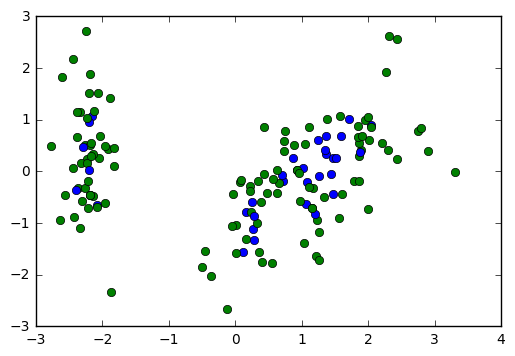

SV are 32


In [5]:
count=0
for i in range(len(iris_values_2d)):
    if 0 < beta_opt_2d[i] < c:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'bo')
        count=count + 1
    else:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'go')

plt.show()
print "SV are %d" %count

In [6]:
def distance_from_center(x_new, x, b_opt, k, gram_term):
    '''
    Computes the squared distance between the image of a point and the center of the found sphere
    
    - x_new: starting point
    - x: array of points to be clustered
    - b_opt: optimal value of variables in the Wolfe dual problem
    - k: kernel function
    - gram_term: common addend based on the Gram matrix
    '''
    
    d1 = k.compute(x_new, x_new)
    d2 = np.array([k.compute(x_i, x_new) for x_i in x]).dot(b_opt)
    d = d1 - 2 * d2 + gram_term
    return d

def squared_radius_and_distance(x, b_opt, k, c):
    '''
    Computes the squared squared radius of the found sphere and a function returning
    the squared distance between the image of a generic point and the sphere center
    
    - x: array of points to be clustered
    - b_opt: optimal value of variables in the Wolfe dual problem
    - k: kernel function
    - c: trade-off parameter
    
    Returns (r, d), where
    
    - r is the squared radius
    - d is the function computing the squared distance
    '''
    
    x_sv = [b for b in b_opt if 0 < b < c]
    gram = np.array(np.array([[k.compute(x1, x2) for x1 in x] for x2 in x]))
    gram_term = np.array(b_opt).dot(gram.dot(b_opt))
    d = lambda x_new: distance_from_center(x_new, x, b_opt, k, gram_term)
    r = [d(sv) for sv in x_sv]
    if len(r) == 0:
        return None
    
    return (np.mean(r), d)




radius, d = squared_radius_and_distance(iris_values_2d, beta_opt_2d, k, c)

print "raggio della sfera: %f" % radius

raggio della sfera: 0.984598


In [7]:
def check_couple(x_start, x_end, radius, d, discretization_size=20):
    
    discretization = np.arange(0., 1+1./discretization_size, 1./discretization_size)
    for x_between in [alpha*x_start + (1-alpha)*x_end for alpha in discretization]:
        if d(x_between) > radius:
            return 0
    return 1

In [13]:
iris_test = np.vstack((iris_values_2d[:5], iris_values_2d[50:55], iris_values_2d[100:105]))

In [14]:
[[check_couple(x_start, x_end, radius, d) for x_start in iris_test] for x_end in iris_test]

[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]

In [10]:
def adjacency_matrix(x,beta,k,cl,cl_i,radius):
    
    couples = []
    couples_i = []
    i=0
    while i < len(cl):
        j=i+1
        while j < len(cl):
            couples.append([cl[i],cl[j]])
            couples_i.append([cl_i[i],cl_i[j]])
            j=j+1
        i=i+1
        
    d3 = np.array(np.array([[k.compute(x1, x2) for x1 in x] for x2 in x]))
    d3 = np.array(beta).dot(d3.dot(beta))
        
    def distance_from_center_2(x,p,fixed):
        d1 = k.compute(p,p)
        d2 = np.array([k.compute(x_i, p) for x_i in x]).dot(beta)
        d = d1 - 2 * d2 + fixed
        return d

    def random_point_on_segment(p1,p2):
        import random
        x1,y1 = p1[0],p1[1]
        x2,y2 = p2[0],p2[1]
        if (x1-x2 != 0):
            x = random.uniform(x1,x2)
            return [x ,((x-x1)*(y2-y1)/(x2-x1) + y1)]
        else:
            return[x1,random.uniform(y1,y2)]

    def same_cluster(p1,p2,np):
        i=0
        while i < np:
            if distance_from_center_2(x,random_point_on_segment(p1,p2),d3) > radius:
                return 0
            i=i+1
        return 1
            
    D = {}
    for i in range(len(couples)):
        D[ (couples_i[i][0],couples_i[i][1]) ] = same_cluster(couples[i][0],couples[i][1],20)
        
    return D
        


D = adjacency_matrix(iris_values_2d,beta_opt_2d,k,cl,cl_i,radius)

In [11]:
import networkx as nx
G=nx.Graph()
G.add_nodes_from(cl_i)

for x in D:
    if D[x]==1:
        G.add_edge(x[0],x[1])

list(nx.connected_components(G))

[{20,
  23,
  25,
  26,
  31,
  36,
  43,
  50,
  51,
  52,
  54,
  55,
  56,
  58,
  59,
  61,
  63,
  64,
  65,
  66,
  67,
  69,
  70,
  71,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99,
  101,
  103,
  110,
  116,
  121,
  123,
  126,
  127,
  133,
  134,
  137,
  138,
  142,
  147,
  149}]